<h2>Ranking Merchants<h2>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F

from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import Layout

spark = (
    SparkSession.builder.appName("Ranking Merchants")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/06 09:58:57 WARN Utils: Your hostname, Sens-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.16 instead (on interface en0)
22/10/06 09:58:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/06 09:58:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
ranking_properties = spark.read.csv('../data/curated/merchant_ranking_properties.csv/', header = True).toPandas()
merchant_names = spark.read.parquet('../data/tables/tbl_merchants.parquet').toPandas()
merchant_names = merchant_names[['merchant_abn', 'name']]
ranking_properties = ranking_properties.astype(float)
segments = pd.read_csv('../data/curated/segmented_merchants.csv')

In [4]:
segments = segments[['merchant_abn', 'merchant_segments']]
segments['merchant_abn'] = segments['merchant_abn'].astype(int)

In [5]:
ranking_properties = ranking_properties.merge(segments, on = 'merchant_abn')

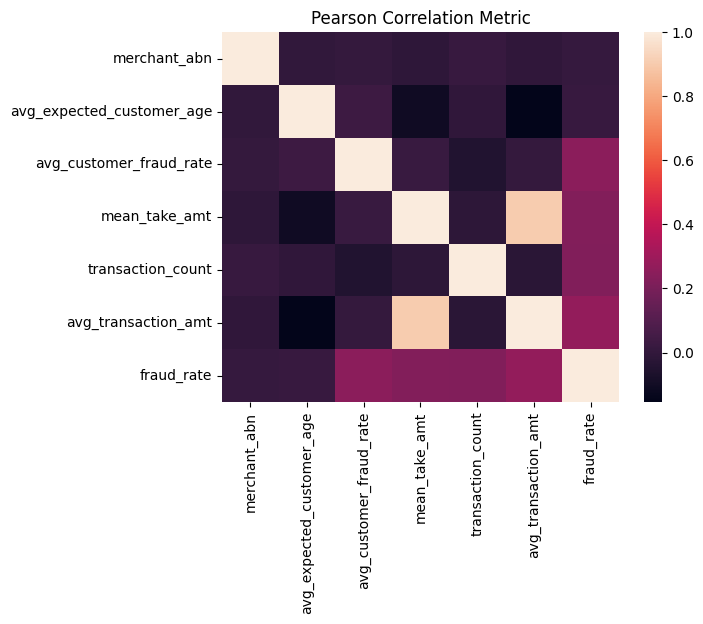

In [6]:
sns.heatmap(ranking_properties.corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/ranking_features_correlation.png', bbox_inches='tight')
plt.show()

Remove average transaction amount because it is correlated with mean take amount and fraud rate. We do not want to use correlated features for ranking because this will effectively increase the weight of these features.



In [7]:
ranking_properties = ranking_properties.drop('avg_transaction_amt', axis = 1)

<h3>Set-up for Different Ranking Methods<h3>

<h4>Weighted Average Rank<h4>

Calculate percentile ranking on each feature for every merchant

In [8]:
# Set whether we want to rank feature in ascending or descending order (if we prefer feature lower or higher)
from pyspark.sql.types import NullType


ascending = {'avg_expected_customer_age': True, 'avg_customer_fraud_rate': True, 'mean_take_amt': False, 'transaction_count': False, 'fraud_rate': True}

# Get ranking on each feature for every merchant

def get_merchant_percent_ranks(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn')
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn')

    ranks = []

    #print(ranking_properties_segment)

    for col_name in (ranking_properties.columns)[1:6]:
        #print(col_name)
        ranking_properties_segment[col_name + '_rank'] = ranking_properties_segment[col_name].rank(ascending = ascending[col_name], pct = True)
        ranks.append(col_name + '_rank')
    
    #print(ranking_properties_segment)
    merchant_percent_ranks = ranking_properties_segment[ranks]

    merchant_percent_ranks_join = merchant_percent_ranks.reset_index()
    merchant_percent_ranks_join['merchant_abn'] = merchant_percent_ranks_join['merchant_abn'].astype(int)

    #ranking_properties_segment = ranking_properties.drop(ranks, axis = 1)

    return merchant_percent_ranks, merchant_percent_ranks_join




<h4>Weighted Normalised Ranking<h4>

Calculate normalised value for all features (between 0 and 1)

Change features that we want to be lower so that they are negative (thus, when we use weights to sum values maximum sum will be best)

In [33]:
def get_merchant_normalised_values(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn').drop(['merchant_segments'], axis = 1)
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn').drop(['merchant_segments'], axis = 1)

    merchant_normalised_features = (ranking_properties_segment-ranking_properties_segment.min())/(ranking_properties_segment.max()-ranking_properties_segment.min())

    for col_name in merchant_normalised_features:
        if ascending[col_name]:
            merchant_normalised_features[col_name] = -1*merchant_normalised_features[col_name]

    merchant_normalised_features_join = merchant_normalised_features.reset_index()
    merchant_normalised_features_join['merchant_abn'] = merchant_normalised_features_join['merchant_abn'].astype(int)

    return merchant_normalised_features, merchant_normalised_features_join

<h3>Interactive Ranking System<h3>

In [12]:
# Set initial weights

w1 = 0.1
w2 = 0.4
w3 = 1
w4 = 1
w5 = 0.8

ranking_type = 'weighted average ranking'

In [43]:
from ipywidgets import interact_manual, widgets, Layout
from numpy._typing import _NBitLongDouble
from pyspark.sql.types import NullType

def weighted_average_rank(w1, w2, w3, w4, w5, segment):
    merchant_percent_ranks, merchant_percent_ranks_join = get_merchant_percent_ranks(segment)

    #print(merchant_percent_ranks)

    merchant_percent_ranks['weighted_average_rank'] = w1*merchant_percent_ranks['avg_expected_customer_age_rank'] + w2*merchant_percent_ranks['avg_customer_fraud_rate_rank']\
         + w3*merchant_percent_ranks['mean_take_amt_rank'] + w4*merchant_percent_ranks['transaction_count_rank']\
             + w5*merchant_percent_ranks['fraud_rate_rank']
    merchant_percent_ranks['rank'] = merchant_percent_ranks['weighted_average_rank'].rank()
    merchant_ranking = merchant_percent_ranks.sort_values(by=['rank'])['rank'].to_frame()
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_percent_ranks_join, on = 'merchant_abn', how = 'outer')
    return merchant_ranking

def weighted_normalised_rank(w1, w2, w3, w4, w5, segment):

    merchant_normalised_features, merchant_normalised_features_join = get_merchant_normalised_values(segment)

    merchant_normalised_features['weighted_normalised_value'] = w1*merchant_normalised_features['avg_expected_customer_age'] + w2*merchant_normalised_features['avg_customer_fraud_rate']\
         + w3*merchant_normalised_features['mean_take_amt'] + w4*merchant_normalised_features['transaction_count']\
             + w5*merchant_normalised_features['fraud_rate']
    merchant_normalised_features['rank'] = merchant_normalised_features['weighted_normalised_value'].rank(ascending = False)
    merchant_ranking = merchant_normalised_features.sort_values(by=['rank'])['rank']
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_normalised_features_join, on = 'merchant_abn', how = 'outer')
    return merchant_ranking
    

def update(customer_age_weight=w1, customer_fraud_weight=w2, mean_take_amt_weight=w3, transaction_count_weight=w4, fraud_rate_weight=w5,ranking_strategy=ranking_type, segment = 'All'):
    if ranking_strategy == 'weighted average rank':
        return weighted_average_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    elif ranking_strategy == 'weighted normalised ranking':
        return weighted_normalised_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    return

im = interact_manual(update, customer_age_weight=(0, 1.0, 0.01), customer_fraud_weight=(0, 1.0, 0.01), mean_take_amt_weight=(0, 1.0, 0.01), \
    transaction_count_weight=(0, 1.0, 0.01), fraud_rate_weight=(0, 1.0, 0.01), ranking_strategy=['weighted average rank', 'weighted normalised ranking'], segment=['All', 'Gardening', 'Appliances', 'Furnitures', 'IT service', 'Accessories']);

descriptions = ['Customer Age Weight----', 'Customer Fraud Weight--', 'Take Amount Weight-----', 'Transaction Count Weight', 'Merchant Fraud Weight---']

for i in range(0,5):
    im.widget.children[i].style = {'description_width': 'initial'}
    im.widget.children[i].layout = Layout(width = '45%')
    im.widget.children[i].description = descriptions[i]

im.widget.children[5].description = 'Ranking Strategy'
im.widget.children[5].style = {'description_width': 'initial'}
im.widget.children[6].description = 'Segment'
im.widget.children[7].description = 'Find Ranking'

display(im)

interactive(children=(FloatSlider(value=0.1, description='customer_age_weight', max=1.0, step=0.01), FloatSlid…

<function __main__.update(customer_age_weight=0.1, customer_fraud_weight=0.4, mean_take_amt_weight=1, transaction_count_weight=1, fraud_rate_weight=0.8, ranking_strategy='weighted average ranking', segment='All')>

<h2>Ranking the Top Merchants<h2>

Prefer weighted average rank because it is more resilient to extreme outliers

From research BNPL groups are primarily affiliated with large corporations with lots of sales, therefore, for rankings we will heavily weight transaction count. Additionally, they prioritise.

<h3>Top 100 Overall<h3>

In [46]:
top_100 = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').head(100)
top_100

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,88358066529,Pede Cras Vulputate Consulting,0.352211,0.331098,0.073522,0.124193,0.345877
1,42543374304,Morbi Metus Vivamus Inc.,0.307253,0.205166,0.158470,0.145306,0.345877
2,74063123996,Nec Eleifend Non Ltd,0.492052,0.222057,0.184302,0.103577,0.345877
3,95574756848,At Pede Inc.,0.537009,0.500994,0.117983,0.056632,0.345877
4,46012371285,A Ultricies Inc.,0.328862,0.520368,0.100348,0.093145,0.345877
...,...,...,...,...,...,...,...
95,88402174457,Duis Dignissim LLC,0.588425,0.224540,0.274218,0.129906,0.345877
96,72738688428,Donec Tempor Corp.,0.563338,0.289866,0.294834,0.086687,0.345877
97,95431176007,Mi Enim Corporation,0.468207,0.442126,0.136364,0.194734,0.345877
98,92065881715,Quam Elementum Corp.,0.638102,0.534277,0.202434,0.076503,0.345877


<h3>Top 10 Each Segment<h3>

<h4>Gardening<h4>

In [45]:
top_10_gardening = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Gardening').head(10)
top_10_gardening

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,74063123996,Nec Eleifend Non Ltd,0.480480,0.216216,0.186186,0.072072,0.399399
1,29639699851,Sodales Elit Erat Corporation,0.453453,0.420420,0.159159,0.045045,0.399399
2,75723980434,Velit Eget Foundation,0.279279,0.315315,0.129129,0.147147,0.399399
3,75850458091,Dictum Sapien Incorporated,0.435435,0.279279,0.204204,0.099099,0.399399
4,22718657980,Ultricies Ornare Associates,0.303303,0.369369,0.123123,0.168168,0.399399
5,53126107676,Sed Neque Corporation,0.582583,0.519520,0.150150,0.060060,0.399399
6,86871438193,Nunc Interdum Inc.,0.549550,0.381381,0.138138,0.135135,0.399399
7,38012560280,In Tempus Associates,0.504505,0.390390,0.228228,0.048048,0.399399
8,18935690984,Semper Et Consulting,0.705706,0.372372,0.153153,0.144144,0.399399
9,99022808555,Turpis In LLC,0.297297,0.375375,0.114114,0.228228,0.399399


<h4>Appliances<h4>

In [47]:
top_10_appliances = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Appliances').head(10)
top_10_appliances

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,88358066529,Pede Cras Vulputate Consulting,0.350846,0.326912,0.056626,0.124927,0.355517
1,95574756848,At Pede Inc.,0.529480,0.495038,0.109749,0.055458,0.355517
2,46012371285,A Ultricies Inc.,0.323993,0.521308,0.087566,0.095155,0.355517
3,45380641195,Nisl Arcu Iaculis Incorporated,0.461763,0.190309,0.217163,0.098074,0.355517
4,88563451053,Nisi PC,0.315236,0.374197,0.100992,0.160537,0.355517
5,41271931352,Ac Sem Ut Company,0.524227,0.395213,0.150613,0.089317,0.355517
6,49536733338,Duis A Ltd,0.471103,0.210158,0.189142,0.131932,0.355517
7,88279777843,Ante Maecenas LLC,0.506130,0.188558,0.171045,0.155283,0.355517
8,63817709749,A Felis Ullamcorper Industries,0.408640,0.520724,0.113252,0.092820,0.355517
9,18303734841,Sollicitudin Orci Ltd,0.307647,0.241681,0.151197,0.180385,0.355517


<h4>Furnitures<h4>

In [48]:
top_10_furnitures = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Furnitures').head(10)
top_10_furnitures

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,32451620193,Malesuada Augue PC,0.269231,0.296703,0.186813,0.142857,0.32967
1,88402174457,Duis Dignissim LLC,0.560440,0.241758,0.252747,0.093407,0.32967
2,14639489823,Auctor Mauris Incorporated,0.659341,0.362637,0.192308,0.120879,0.32967
3,86182863634,Luctus Vulputate Nisi Institute,0.631868,0.274725,0.214286,0.153846,0.32967
4,48997695741,Lorem Tristique Institute,0.340659,0.445055,0.230769,0.115385,0.32967
5,46533246372,Ut Quam Inc.,0.214286,0.401099,0.175824,0.208791,0.32967
6,21094505909,Venenatis Corp.,0.274725,0.593407,0.164835,0.137363,0.32967
7,92636306985,Ornare Incorporated,0.615385,0.236264,0.236264,0.175824,0.32967
8,24471518053,Enim Suspendisse Aliquet LLP,0.543956,0.329670,0.318681,0.082418,0.32967
9,10323485998,Nunc Inc.,0.510989,0.379121,0.329670,0.060440,0.32967


<h4>IT service<h4>

In [49]:
top_10_it_service = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'IT service').head(10)
top_10_it_service

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,42543374304,Morbi Metus Vivamus Inc.,0.308901,0.272251,0.026178,0.157068,0.471204
1,63978837398,In Tincidunt PC,0.612565,0.230366,0.036649,0.172775,0.471204
2,87771712045,Vivamus Sit LLC,0.743455,0.293194,0.031414,0.167539,0.471204
3,45244796758,Vitae Dolor LLP,0.507853,0.356021,0.151832,0.057592,0.471204
4,22526511302,Semper Et Incorporated,0.434555,0.345550,0.068063,0.162304,0.471204
5,22027671078,Mauris Magna Industries,0.314136,0.287958,0.209424,0.104712,0.471204
6,55090181035,Dictum Ultricies Ltd,0.397906,0.664921,0.015707,0.141361,0.471204
7,29641342749,Et Associates,0.387435,0.445026,0.193717,0.052356,0.471204
8,74319969182,Morbi Tristique Corp.,0.298429,0.324607,0.020942,0.329843,0.471204
9,95431176007,Mi Enim Corporation,0.460733,0.565445,0.010471,0.230366,0.471204


<h4>Accessories<h4>

In [50]:
top_10_accessories = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Accessories').head(10)
top_10_accessories

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,70893725439,Luctus Curabitur Incorporated,0.341630,0.165526,0.137523,0.210330,0.312694
1,71759376949,Pharetra Corp.,0.514624,0.588052,0.053516,0.109521,0.312694
2,61080648284,Lobortis Ultrices LLC,0.319851,0.555072,0.082763,0.158058,0.312694
3,68435002949,Aliquam Eu Inc.,0.487866,0.312383,0.166770,0.156192,0.312694
4,70033549200,Mus Proin LLP,0.427505,0.652769,0.098942,0.096453,0.312694
5,52594457116,Vel Turpis Aliquam Company,0.357810,0.584319,0.121966,0.110765,0.312694
6,98072939449,Mattis Velit Justo Ltd,0.470442,0.669571,0.070317,0.118855,0.312694
7,89022158521,Sollicitudin Adipiscing Ltd,0.496577,0.628500,0.113255,0.090853,0.312694
8,66842618444,Ultrices Inc.,0.423149,0.342253,0.186061,0.140635,0.312694
9,13255205539,In Aliquet Inc.,0.431861,0.322962,0.116366,0.219664,0.312694
